# Presto

- Github - [prestodb/presto-python-client](https://github.com/prestodb/presto-python-client)
- Github - [dropbox/PyHive](https://github.com/dropbox/PyHive)

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import shapely.wkt
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import prestodb

pd.__version__, gpd.__version__, prestodb.__version__

('1.0.5', '0.8.0', '0.7.0')

In [4]:
PRESTO_CONNECTION = dict(
    host='localhost',
    port=8080,
    user='hadoop',
    catalog='hive',
    schema='default'
)

## Show Hive Tables

In [4]:
with prestodb.dbapi.connect(**PRESTO_CONNECTION) as connection:
    cursor = connection.cursor()
    cursor.execute("SHOW TABLES")
    for row in cursor.fetchall():
        print(row[0])

gdelt_csv_2019
gdelt_csv_2020
gdelt_parquet_2020
gdelt_parquet_inserted_2019
gdelt_parquet_inserted_2020
ne_10_states_provinces_parquet
ne_110_countries_parquet


## Helper Function

In [5]:
def run_query(verbose=True, **args):
    with prestodb.dbapi.connect(**args) as connection:
        cursor = connection.cursor()
        cursor.execute(query)

        items = cursor.fetchall()
        columns = [v[0] for v in cursor.description]
        df = pd.DataFrame(items, columns=columns)

        if verbose:
            stats = cursor.stats
            print(stats['state'], 'in', stats['elapsedTimeMillis'], 'ms')
            print('num nodes :', stats['nodes'])
            print("Query :", stats['queryId'])
            print("Splits :", stats['rootStage']['completedSplits'], "/", stats['rootStage']['totalSplits'])

    return df

In [8]:
%%time
query = """
  SELECT COUNT(event_id) AS cnt 
  FROM gdelt_parquet_inserted_2020
"""

run_query(query, **PRESTO_CONNECTION)

FINISHED in 4066 ms
num nodes : 3
Query : 20201010_135025_00068_vw22n
Splits : 17 / 17
CPU times: user 56 ms, sys: 342 µs, total: 56.4 ms
Wall time: 4.12 s


,cnt
0,24330238


In [ ]:
%%time
query = """
  EXPLAIN ANALYZE SELECT COUNT(event_id) AS cnt 
  FROM gdelt_parquet_inserted_2020
"""

with prestodb.dbapi.connect(**PRESTO_CONNECTION) as connection:
    cursor = connection.cursor()
    cursor.execute(query)
    items = cursor.fetchall()
    print(items[0][0])

In [6]:
%%time
query = """
  EXPLAIN ANALYZE SELECT event_id
  FROM gdelt_parquet_inserted_2020 LIMIT 10
"""

with prestodb.dbapi.connect(**PRESTO_CONNECTION) as connection:
    cursor = connection.cursor()
    cursor.execute(query)
    items = cursor.fetchall()
    print(items[0][0])

Fragment 1 [SINGLE]
    CPU: 24.87ms, Scheduled: 490.57ms, Input: 110 rows (990B); per task: avg.: 110.00 std.dev.: 0.00, Output: 10 rows (90B)
    Output layout: [event_id]
    Output partitioning: SINGLE []
    Stage Execution Strategy: UNGROUPED_EXECUTION
    - Limit[10] => [event_id:bigint]
            CPU: 1.00ms (0.05%), Scheduled: 37.00ms (0.12%), Output: 10 rows (90B)
            Input avg.: 11.00 rows, Input std.dev.: 0.00%
        - LocalExchange[SINGLE] () => [event_id:bigint]
                CPU: 10.00ms (0.50%), Scheduled: 131.00ms (0.41%), Output: 11 rows (99B)
                Input avg.: 6.88 rows, Input std.dev.: 291.95%
            - RemoteSource[2] => [event_id:bigint]
                    CPU: 4.00ms (0.20%), Scheduled: 19.00ms (0.06%), Output: 110 rows (990B)
                    Input avg.: 6.88 rows, Input std.dev.: 291.95%

Fragment 2 [SOURCE]
    CPU: 1.99s, Scheduled: 23.11s, Input: 285 rows (2.50kB); per task: avg.: 95.00 std.dev.: 61.64, Output: 190 rows (1.67k

In [11]:
%%time
query = """
    SELECT 
      event_id,
      event_root_code,
      lat,
      lon
    FROM gdelt_parquet_inserted_2020 
    LIMIT 10
"""

df = run_query(query, **PRESTO_CONNECTION)
df.head()

FINISHED in 1921 ms
num nodes : 3
Query : 20200921_081829_00012_vw22n
Splits : 17 / 17


,event_id,event_root_code,lat,lon
0,930152445,4,40.3736,-82.7755
1,930152446,2,40.3736,-82.7755
2,930152447,1,45.7326,-93.9196
3,930152448,8,40.5944,-111.4270
4,930152449,8,40.5944,-111.4270


# Presto Geospatial Functions

- [Geospatial Functions](https://prestodb.io/docs/current/functions/geospatial.html)

In [12]:
query = """
    SELECT 
      event_root_code,
      ST_Point(lon, lat) AS pt 
    FROM gdelt_parquet_inserted_2020 
    LIMIT 10
"""

df = run_query(query, **PRESTO_CONNECTION)
df.head()

FINISHED in 1154 ms
num nodes : 3
Query : 20200921_081836_00013_vw22n
Splits : 33 / 33


,event_root_code,pt
0,1,POINT (-93.214 42.0046)
1,8,POINT (-93.214 42.0046)
2,8,POINT (-91.2213 45.7688)
3,3,POINT (-74.9384 42.1497)
4,11,POINT (12.833333 42.833333)


# Query all Points within Geometry

In [19]:
filepath = "/home/hadoop/sgds/data/naturalearth/" \
           "ne_110m_admin_0_countries.shp"

gdf_ne = gpd.read_file(filepath)

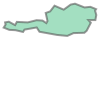

In [31]:
mask = gdf_ne['ISO_A2'] == 'AT'
geom = gdf_ne[mask].iloc[0]['geometry']
geom

In [36]:
%%time
query = """
    SELECT 
      event_date, 
      event_root_code, 
      ST_Point(lon, lat) AS geom
    FROM gdelt_parquet_inserted_2020
    WHERE ST_Intersects(
      ST_Point(lon, lat), 
      ST_GeometryFromText('{}')
    )
""".format(geom.wkt)

df = run_query(query, **PRESTO_CONNECTION)
df.head()

FINISHED in 3143 ms
num nodes : 3
Query : 20200921_082844_00018_vw22n
Splits : 16 / 16
CPU times: user 477 ms, sys: 14.7 ms, total: 492 ms
Wall time: 3.4 s


,event_date,event_root_code,geom
0,2020-06-05,1,POINT (16.3667 48.2)
1,2020-06-05,17,POINT (13.333333 47.333333)
2,2020-06-05,7,POINT (16.3667 48.2)
3,2020-06-05,8,POINT (13.333333 47.333333)
4,2020-06-05,8,POINT (13.333333 47.333333)


In [37]:
df['geom'] = df['geom'].apply(shapely.wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='epsg:4326')

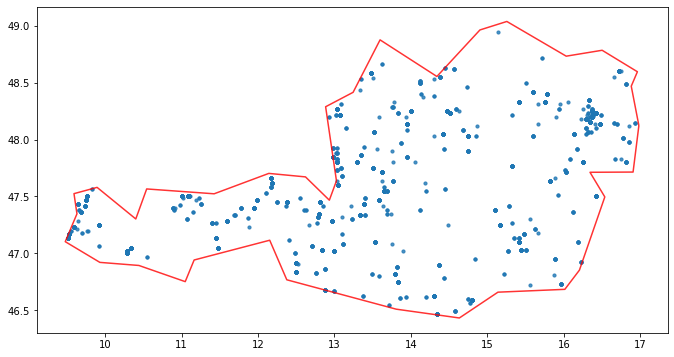

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf.plot(ax=ax, alpha=0.8, markersize=10)
gdf_ne[mask].boundary.plot(ax=ax, color='r', alpha=0.8);

# Bing Tiles

In [17]:
%%time
query = """
    WITH counts AS (
      SELECT
        COUNT(*) AS cnt,
        bing_tile_at(lat, lon, 6) AS tile
      FROM gdelt_parquet_inserted_2020
      WHERE -85 < lat AND lat < 85
      GROUP BY 2
    )
    
    SELECT 
      cnt, 
      tile, 
      bing_tile_polygon(tile) AS geom
    FROM counts
""".format(extent_wkt)

df = run_query(query, **PRESTO_CONNECTION)
df.head()

FINISHED in 25361 ms
num nodes : 3
Query : 20200921_082403_00016_vw22n
Splits : 16 / 16
CPU times: user 122 ms, sys: 17.4 ms, total: 139 ms
Wall time: 25.8 s


,cnt,tile,geom
0,60633,"{'x': 53, 'y': 26, 'zoom': 6}","POLYGON ((118.125 27.05912578437406, 123.75 27..."
1,28541,"{'x': 54, 'y': 30, 'zoom': 6}","POLYGON ((123.75 5.615985819155327, 129.375 5...."
2,17286,"{'x': 35, 'y': 18, 'zoom': 6}","POLYGON ((16.875 58.813741715707806, 22.5 58.8..."
3,1805,"{'x': 28, 'y': 17, 'zoom': 6}","POLYGON ((-22.5 61.60639637138627, -16.875 61...."
4,969,"{'x': 35, 'y': 19, 'zoom': 6}","POLYGON ((16.875 55.77657301866769, 22.5 55.77..."


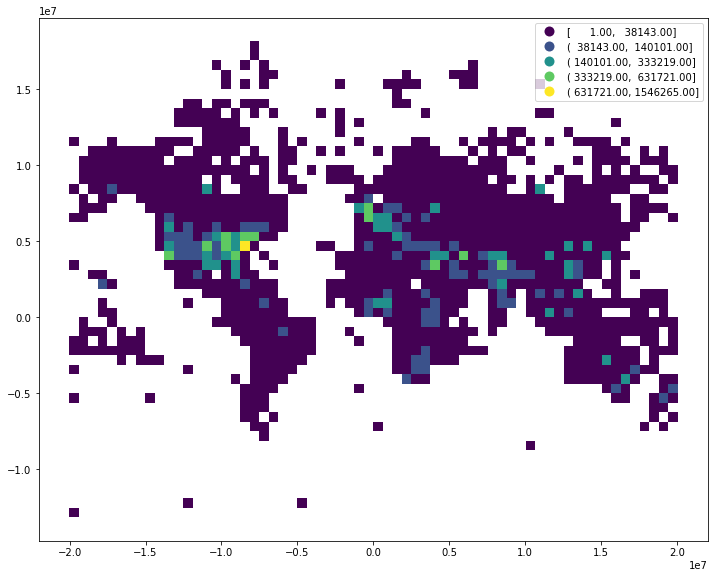

In [18]:
df = df.dropna(subset=['geom'])
df['geom'] = df['geom'].apply(shapely.wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='epsg:4326')

gdf.to_crs(epsg=3857).plot(column='cnt', 
                           cmap='viridis', 
                           scheme='naturalbreaks', k=5,
                           figsize=(12, 10),
                           legend=True);

# Spatial Join

In [67]:
%%time
query = """
    WITH countries AS (
      SELECT 
        ne_id,
        iso_a2,
        ST_GeomFromBinary(geometry) AS geometry
      FROM ne_110_countries_parquet
    ), points AS (
       SELECT
         event_root_code, 
         ST_Point(lon, lat) AS point
       FROM gdelt_parquet_inserted_2020
    ), counts AS (
      SELECT 
        countries.ne_id,
        COUNT(*) AS cnt
      FROM points, countries
      WHERE ST_Contains(countries.geometry, points.point)
      GROUP BY (
        countries.ne_id
      )
    )
    
    SELECT 
      counts.ne_id,
      counts.cnt,
      countries.iso_a2,
      countries.geometry
    FROM
      counts,
      countries
    WHERE
      counts.ne_id = countries.ne_id
"""

df = run_query(query, **PRESTO_CONNECTION)
df.head()

FINISHED in 52444 ms
num nodes : 3
Query : 20200921_085836_00024_vw22n
Splits : 16 / 16
CPU times: user 252 ms, sys: 30.4 ms, total: 282 ms
Wall time: 52.5 s


,ne_id,cnt,iso_a2,geometry
0,1159321081,26479,MW,MULTIPOLYGON (((32.75937544122132 -9.230599053...
1,1159321087,21152,NE,MULTIPOLYGON (((14.851300000000037 22.86295000...
2,1159321061,7898,MK,MULTIPOLYGON (((22.380525750424592 42.32025950...
3,1159320815,17240,GT,MULTIPOLYGON (((-92.22775000686983 14.53882864...
4,1159321253,11568,SV,MULTIPOLYGON (((-89.35332597528281 14.42413279...


In [69]:
df['geometry'] = df['geometry'].apply(shapely.wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='epsg:4326')

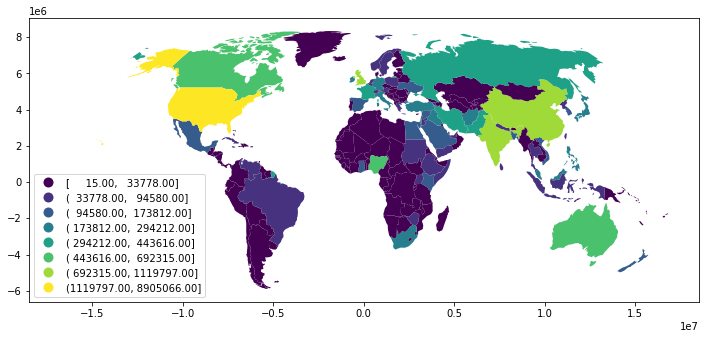

In [74]:
# Remove Antarctica
mask = gdf['iso_a2'] != 'AQ'

ax = gdf[mask].to_crs({'proj': 'robin'}).plot(column='cnt', 
                                 cmap='viridis', 
                                 scheme='naturalbreaks', k=8,
                                 figsize=(12, 10),
                                 legend=True,
                                 legend_kwds={'loc': 'lower left'});